In [1]:
from pynvml import *

nvmlInit()
vram = nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(0)).free/1024.**2
print('GPU0 Memory: %dMB' % vram)
if vram < 8000:
    raise Exception('GPU Memory too low')

GPU0 Memory: 10386MB


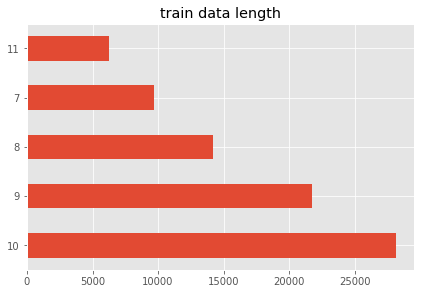

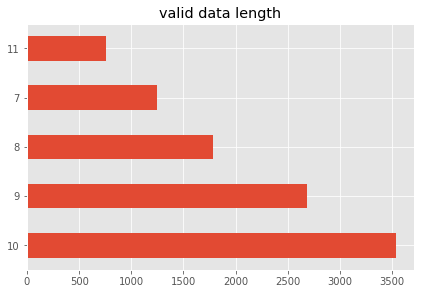

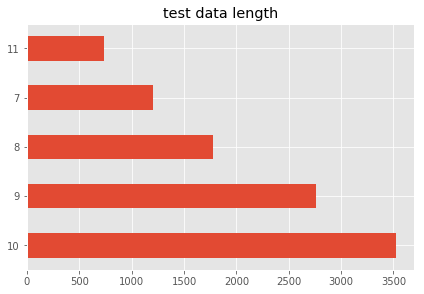

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# 统计字符长度
def draw_hist(data, title):
    plt.style.use(u'ggplot')
    fig = pd.DataFrame(data, index=[0]).transpose()[0].plot(kind='barh')
    fig = fig.get_figure()
    fig.tight_layout()
    plt.title(title)
    plt.show()

data_csv = pd.read_csv('G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train.csv')
img_dirpath = data_csv['filename'].tolist()
label = data_csv['label'].tolist()
X_data, X_valid, y_data, y_valid = train_test_split(img_dirpath, label, test_size=10000, random_state=17)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=10000, random_state=17)
list_length_train = list()
for str in y_train:
    list_length_train.append(len(str))
list_length_train = pd.Series(list_length_train).value_counts().to_dict()
draw_hist(list_length_train, 'train data length')

list_length_valid = list()
for str in y_valid:
    list_length_valid.append(len(str))
list_length_valid = pd.Series(list_length_valid).value_counts().to_dict()
draw_hist(list_length_valid,'valid data length')

list_length_test = list()
for str in y_test:
    list_length_test.append(len(str))
list_length_test = pd.Series(list_length_test).value_counts().to_dict()
draw_hist(list_length_test,'test data length')


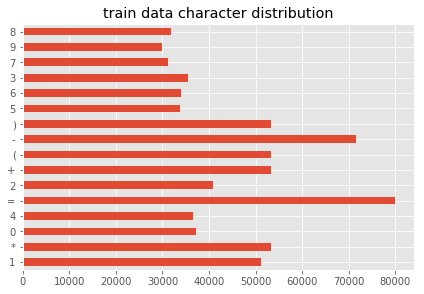

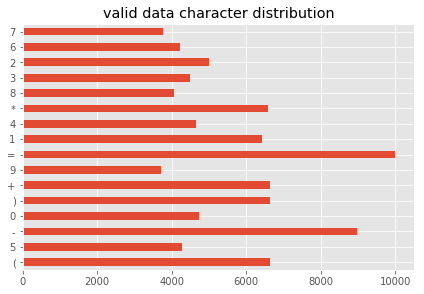

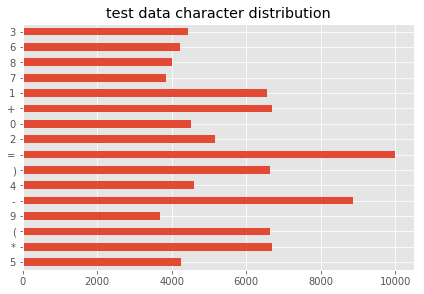

In [3]:
# 统计字符分布
from collections import defaultdict
sum_character_train = defaultdict(int)
for str in y_train:
    for character in str:
        sum_character_train[character] += 1
sum_character_train = dict(sum_character_train)
draw_hist(sum_character_train,'train data character distribution')

sum_character_valid = defaultdict(int)
for str in y_valid:
    for character in str:
        sum_character_valid[character] += 1
sum_character_valid = dict(sum_character_valid)
draw_hist(sum_character_valid,'valid data character distribution')

sum_character_test = defaultdict(int)
for str in y_test:
    for character in str:
        sum_character_test[character] += 1
sum_character_test = dict(sum_character_test)
draw_hist(sum_character_test,'test data character distribution')

In [4]:
# 所有待识别字符
CHAR_VECTOR = "0123456789+-*()=a"
letters = [letter for letter in CHAR_VECTOR]

In [5]:
# 将索引转换为字符
def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))
# 将字符转换为索引
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

In [6]:
import cv2
import random
from tqdm import tqdm

class TextImageGenerator:
    def __init__(self, rootpath, img_dirpath, label, img_w, img_h, batch_size, downsample_factor, max_text_len):
        self.rootpath = rootpath # 文件根目录
        self.img_dirpath = img_dirpath
        self.label = label
        self.img_w = img_w
        self.img_h = img_h
        self.batch_size = batch_size
        self.downsample_factor = downsample_factor
        self.max_text_len = max_text_len
        self.n = len(self.img_dirpath) # 图片数量
        self.indexes = list(range(self.n))
        self.cur_index = 0
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []

    def build_data(self):
        for i, img_file in enumerate(tqdm(self.img_dirpath)):
            img = cv2.imread(self.rootpath + img_file, cv2.IMREAD_GRAYSCALE)
#             print(self.rootpath + img_file)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img = (img / 255.0) * 2.0 - 1.0
            self.imgs[i, :, :] = img
            self.texts.append(self.label[i])
        print(self.n, " Image Loading finish...")

    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]

    def next_batch(self):
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.empty([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img
                labels = text_to_labels(text)
                Y_data[i, 0:len(labels)] = labels
                Y_data[i, len(labels):13] = 16
                label_length[i] = len(text)

            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [7]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


In [8]:
from keras.layers import *
from keras.models import *

def get_model(img_w, img_h, num_classes, training):
    input_shape = (img_w, img_h, 1)  # (128, 64, 1)

    # Make Networkw
    inputs = Input(name='the_input', shape=input_shape, dtype='float32') # (None, 128, 64, 1)

    # Convolution layer (VGG)
    inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs)  # (None, 128, 64, 64)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None,64, 32, 64)
#     inner = Dropout(0.2)(inner)

    inner = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  # (None, 64, 32, 128)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  # (None, 32, 16, 128)
#     inner = Dropout(0.2)(inner)

    inner = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  # (None, 32, 8, 256)
#     inner = Dropout(0.2)(inner)

#     inner = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)  # (None, 32, 8, 512)
#     inner = BatchNormalization()(inner)
#     inner = Activation('relu')(inner)
#     inner = Conv2D(512, (3, 3), padding='same', name='conv6')(inner)  # (None, 32, 8, 512)
#     inner = BatchNormalization()(inner)
#     inner = Activation('relu')(inner)
#     inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)  # (None, 32, 4, 512)
#     inner = Dropout(0.2)(inner)

    inner = Conv2D(256, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(inner)  # (None, 32, 4, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)

    # CNN to RNN
    inner = Reshape(target_shape=((32, 2048)), name='reshape')(inner)  # (None, 32, 2048)
    inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)  # (None, 32, 64)

    # RNN layer
    lstm_1 = GRU(256, return_sequences=True, kernel_initializer='he_normal', name='lstm1')(inner)  # (None, 32, 512)
    lstm_1b = GRU(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm1_b')(inner)
    lstm1_merged = add([lstm_1, lstm_1b])  # (None, 32, 512)
    lstm1_merged = BatchNormalization()(lstm1_merged)
    lstm_2 = GRU(256, return_sequences=True, kernel_initializer='he_normal', name='lstm2')(lstm1_merged)
    lstm_2b = GRU(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm2_b')(lstm1_merged)
    lstm2_merged = concatenate([lstm_2, lstm_2b])  # (None, 32, 1024)
    lstm2_merged = Dropout(0.2)(lstm2_merged)
#     lstm_merged = BatchNormalization()(lstm2_merged)

    # transforms RNN output to character activations:
    inner = Dense(num_classes, kernel_initializer='he_normal', name='dense2')(lstm2_merged) #(None, 32, 63)
    y_pred = Activation('softmax', name='softmax')(inner)

    labels = Input(name='the_labels', shape=[max_text_len], dtype='float32') # (None ,8)
    input_length = Input(name='input_length', shape=[1], dtype='int64')     # (None, 1)
    label_length = Input(name='label_length', shape=[1], dtype='int64')     # (None, 1)

    # Keras doesn't currently support loss funcs with extra parameters so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length]) #(None, 1)

    if training:
        return Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)
    else:
        return Model(inputs=[inputs], outputs=y_pred)

In [9]:
# 绘制准确率
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'b-')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.savefig("Training and validation accuracy.png")
    plt.figure()
    plt.plot(epochs, loss, 'b-')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.savefig("Training and validation loss.png")
    plt.show()

In [10]:
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

rootpath = 'G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/'

img_w, img_h = 128, 64
batch_size = 256
downsample_factor = 4
max_text_len = 12
num_classes = len(letters) + 1

model = get_model(img_w, img_h, num_classes, True)
plot_model(model, to_file='model.png', show_shapes=True)

try:
    model.load_weights('best_weight.hdf5')
    print("...Previous weight data...")
except:
    print("...New weight data...")
    pass

data_train = TextImageGenerator(rootpath, X_train, y_train, img_w, img_h, batch_size, downsample_factor, max_text_len)
data_train.build_data()
data_valid = TextImageGenerator(rootpath, X_valid, y_valid, img_w, img_h, batch_size, downsample_factor, max_text_len)
data_valid.build_data()
data_test = TextImageGenerator(rootpath, X_test, y_test, img_w, img_h, batch_size, downsample_factor, max_text_len)
data_test.build_data()

checkpoint = ModelCheckpoint(filepath='best_weight.hdf5', monitor='val_acc', verbose=0, save_best_only=True, period=1)

...New weight data...


100%|███████████████████████████████████████████████████████████████████████████| 80000/80000 [02:46<00:00, 479.69it/s]


80000  Image Loading finish...


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 470.76it/s]


10000  Image Loading finish...


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 472.20it/s]


10000  Image Loading finish...


Epoch 1/50
 - 151s - loss: 12.2985 - acc: 1.6276e-04 - val_loss: 5.5013 - val_acc: 1.0016e-04
Epoch 2/50
 - 148s - loss: 1.4641 - acc: 0.3993 - val_loss: 1.0332 - val_acc: 0.5707
Epoch 3/50
 - 148s - loss: 0.4683 - acc: 0.8227 - val_loss: 0.5582 - val_acc: 0.8054
Epoch 4/50
 - 148s - loss: 0.2648 - acc: 0.9073 - val_loss: 0.3791 - val_acc: 0.8647
Epoch 5/50
 - 148s - loss: 0.1442 - acc: 0.9478 - val_loss: 1.8864 - val_acc: 0.6113
Epoch 6/50
 - 148s - loss: 0.1304 - acc: 0.9603 - val_loss: 0.6304 - val_acc: 0.8317
Epoch 7/50
 - 148s - loss: 0.0877 - acc: 0.9693 - val_loss: 0.4106 - val_acc: 0.8933
Epoch 8/50
 - 148s - loss: 0.0802 - acc: 0.9751 - val_loss: 0.1846 - val_acc: 0.9456
Epoch 9/50
 - 148s - loss: 0.0488 - acc: 0.9842 - val_loss: 0.2257 - val_acc: 0.9369
Epoch 10/50
 - 148s - loss: 0.0521 - acc: 0.9849 - val_loss: 0.2241 - val_acc: 0.9354
Epoch 11/50
 - 148s - loss: 0.0319 - acc: 0.9896 - val_loss: 0.1422 - val_acc: 0.9651
Epoch 12/50
 - 148s - loss: 0.0264 - acc: 0.9920 - val

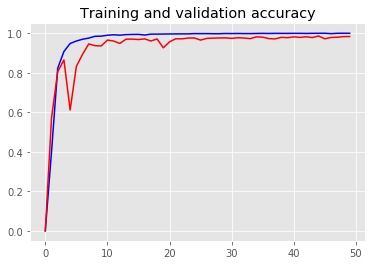

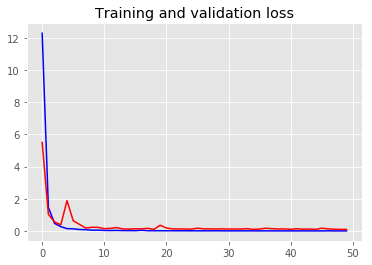

In [11]:

# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adadelta(), metrics=['accuracy'])

history_ft = model.fit_generator(generator=data_train.next_batch(),
                    steps_per_epoch=int(data_train.n / batch_size),
                    epochs=50,
                    verbose = 2,
                    callbacks=[checkpoint],
                    validation_data=data_valid.next_batch(),
                    validation_steps=int(data_valid.n / batch_size))

plot_training(history_ft)

In [12]:
# model.save('model_acc9964_valacc_9868.h5')

In [26]:
import itertools

def decode_label(out):
    out_best = list(np.argmax(out[0, 2:], axis=1))  # get max index
    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value
    outstr = ''
    for i in out_best:
        if i < len(letters):
            outstr += letters[i]
    return outstr

model_best = get_model(img_w, img_h, num_classes, False)
model_best.load_weights("best_weight.hdf5")

total = 0
acc = 0
letter_total = 0
letter_acc = 0

for i, img_file in tqdm(enumerate(X_test)):
    img = cv2.imread( rootpath+ img_file, cv2.IMREAD_GRAYSCALE)
    img_pred = img.astype(np.float32)
    img_pred = cv2.resize(img_pred, (128, 64))
    img_pred = (img_pred / 255.0) * 2.0 - 1.0
    img_pred = img_pred.T
    img_pred = np.expand_dims(img_pred, axis=-1)
    img_pred = np.expand_dims(img_pred, axis=0)
    net_out_value = model_best.predict(img_pred)
    pred_texts = decode_label(net_out_value)
    
    for j in range(min(len(pred_texts), len(y_test[i]))):
        if pred_texts[j] == y_test[i][j]:
            letter_acc += 1
    letter_total += max(len(pred_texts), len(label[i]))

    if pred_texts == y_test[i]:
        acc += 1
    else:
        print(img_file)
    total += 1

print("ACC : ", acc / total)
print("letter ACC : ", letter_acc / letter_total)

136it [00:03, 45.97it/s]

train/61947.jpg


161it [00:03, 43.79it/s]

train/62460.jpg


166it [00:04, 44.08it/s]

train/17349.jpg


171it [00:04, 44.17it/s]

train/88434.jpg


221it [00:05, 44.98it/s]

train/74584.jpg


256it [00:06, 43.40it/s]

train/64396.jpg


351it [00:08, 45.61it/s]

train/52333.jpg


371it [00:08, 44.70it/s]

train/80762.jpg


551it [00:12, 44.68it/s]

train/29432.jpg


621it [00:14, 44.95it/s]

train/21325.jpg


666it [00:15, 43.82it/s]

train/32335.jpg


681it [00:15, 44.17it/s]

train/12270.jpg


751it [00:17, 44.44it/s]

train/58395.jpg


796it [00:18, 45.28it/s]

train/72013.jpg


836it [00:19, 43.75it/s]

train/92815.jpg


871it [00:19, 43.67it/s]

train/45832.jpg
train/47541.jpg


911it [00:20, 40.86it/s]

train/70087.jpg


1006it [00:23, 44.25it/s]

train/95905.jpg


1146it [00:26, 44.15it/s]

train/11948.jpg


1191it [00:27, 44.91it/s]

train/6626.jpg


1376it [00:31, 45.45it/s]

train/13368.jpg


1411it [00:32, 45.70it/s]

train/96687.jpg


1541it [00:35, 45.26it/s]

train/94980.jpg


1641it [00:37, 44.58it/s]

train/35002.jpg


1701it [00:38, 44.70it/s]

train/67074.jpg


1751it [00:39, 44.74it/s]

train/19158.jpg


1931it [00:43, 45.01it/s]

train/20814.jpg


1961it [00:44, 45.12it/s]

train/24130.jpg


1996it [00:45, 45.80it/s]

train/55813.jpg


2041it [00:46, 45.02it/s]

train/31906.jpg


2056it [00:46, 43.33it/s]

train/3267.jpg


2076it [00:46, 44.00it/s]

train/58258.jpg


2191it [00:49, 45.13it/s]

train/71218.jpg


2331it [00:52, 44.84it/s]

train/16788.jpg


2396it [00:54, 45.18it/s]

train/68277.jpg


2491it [00:56, 45.95it/s]

train/80018.jpg


2511it [00:56, 45.16it/s]

train/61510.jpg


2516it [00:56, 44.92it/s]

train/24810.jpg


2606it [00:58, 44.74it/s]

train/30491.jpg


2631it [00:59, 44.07it/s]

train/51008.jpg


2841it [01:04, 45.37it/s]

train/44391.jpg
train/88604.jpg


2851it [01:04, 44.98it/s]

train/14242.jpg


2931it [01:06, 45.65it/s]

train/62217.jpg


2981it [01:07, 46.18it/s]

train/80330.jpg


3021it [01:07, 45.46it/s]

train/58477.jpg


3091it [01:09, 44.53it/s]

train/89490.jpg


3111it [01:10, 43.87it/s]

train/28612.jpg


3191it [01:11, 45.39it/s]

train/54150.jpg


3206it [01:12, 45.08it/s]

train/49853.jpg


3251it [01:13, 44.05it/s]

train/83498.jpg


3261it [01:13, 44.28it/s]

train/65360.jpg


3376it [01:15, 45.47it/s]

train/98488.jpg


3386it [01:16, 45.10it/s]

train/92081.jpg


3536it [01:19, 45.85it/s]

train/51144.jpg


3541it [01:19, 45.15it/s]

train/48156.jpg


3546it [01:19, 44.55it/s]

train/32219.jpg


3661it [01:22, 43.59it/s]

train/95770.jpg


3791it [01:25, 44.55it/s]

train/26328.jpg


3901it [01:27, 44.43it/s]

train/71146.jpg


3916it [01:28, 43.67it/s]

train/63270.jpg
train/33668.jpg


3926it [01:28, 44.66it/s]

train/43023.jpg


3976it [01:29, 44.24it/s]

train/9402.jpg


4166it [01:33, 44.87it/s]

train/11802.jpg


4236it [01:35, 45.01it/s]

train/52321.jpg


4271it [01:36, 44.43it/s]

train/3258.jpg


4561it [01:42, 41.73it/s]

train/89532.jpg


4571it [01:42, 41.35it/s]

train/1869.jpg


4601it [01:43, 43.69it/s]

train/61735.jpg


4626it [01:44, 43.67it/s]

train/72093.jpg


4661it [01:44, 43.37it/s]

train/12561.jpg


4666it [01:45, 43.78it/s]

train/10249.jpg


4856it [01:49, 45.10it/s]

train/59963.jpg


4881it [01:49, 44.80it/s]

train/31661.jpg


4891it [01:50, 44.45it/s]

train/58922.jpg


4996it [01:52, 44.94it/s]

train/18439.jpg


5016it [01:53, 44.96it/s]

train/3687.jpg


5041it [01:53, 45.10it/s]

train/61660.jpg


5066it [01:54, 45.16it/s]

train/16233.jpg


5166it [01:56, 45.01it/s]

train/55041.jpg


5191it [01:56, 45.54it/s]

train/83796.jpg


5246it [01:58, 45.86it/s]

train/60838.jpg


5276it [01:58, 44.56it/s]

train/40543.jpg


5496it [02:03, 45.23it/s]

train/73993.jpg


5551it [02:04, 45.04it/s]

train/21010.jpg


5561it [02:05, 45.21it/s]

train/42772.jpg
train/53708.jpg


5711it [02:08, 45.53it/s]

train/72484.jpg


5726it [02:08, 45.78it/s]

train/36391.jpg


5756it [02:09, 45.99it/s]

train/25545.jpg


5821it [02:10, 44.47it/s]

train/4407.jpg


5826it [02:10, 44.09it/s]

train/78925.jpg


5911it [02:12, 43.37it/s]

train/17358.jpg


5951it [02:13, 44.61it/s]

train/34522.jpg


5981it [02:14, 44.48it/s]

train/1087.jpg


6016it [02:15, 44.50it/s]

train/85303.jpg


6051it [02:16, 43.07it/s]

train/44371.jpg


6061it [02:16, 43.59it/s]

train/47183.jpg


6111it [02:17, 44.92it/s]

train/81585.jpg


6171it [02:18, 44.55it/s]

train/69916.jpg


6286it [02:21, 44.64it/s]

train/51169.jpg


6396it [02:23, 43.88it/s]

train/84900.jpg


6401it [02:23, 43.79it/s]

train/22261.jpg


6421it [02:24, 43.87it/s]

train/83500.jpg


6431it [02:24, 43.76it/s]

train/4286.jpg


6441it [02:24, 43.90it/s]

train/674.jpg


6446it [02:24, 43.46it/s]

train/99929.jpg


6461it [02:25, 44.38it/s]

train/71313.jpg


6476it [02:25, 43.05it/s]

train/58549.jpg


6531it [02:26, 44.74it/s]

train/70714.jpg


6561it [02:27, 44.22it/s]

train/86867.jpg


6566it [02:27, 44.50it/s]

train/88702.jpg


6576it [02:27, 44.63it/s]

train/41508.jpg


6651it [02:29, 44.46it/s]

train/6572.jpg


6661it [02:29, 45.56it/s]

train/9556.jpg


6836it [02:33, 43.91it/s]

train/26419.jpg


6911it [02:35, 43.63it/s]

train/35343.jpg


6996it [02:37, 43.06it/s]

train/82426.jpg


7041it [02:38, 45.41it/s]

train/23082.jpg


7046it [02:38, 45.71it/s]

train/76545.jpg


7126it [02:40, 43.21it/s]

train/11694.jpg


7166it [02:41, 44.12it/s]

train/67877.jpg


7216it [02:42, 44.09it/s]

train/79037.jpg


7401it [02:46, 45.57it/s]

train/76057.jpg


7436it [02:47, 45.66it/s]

train/86698.jpg


7446it [02:47, 45.00it/s]

train/38918.jpg


7451it [02:47, 44.69it/s]

train/38817.jpg


7501it [02:48, 45.64it/s]

train/25861.jpg


7521it [02:49, 44.96it/s]

train/13678.jpg


7751it [02:54, 44.83it/s]

train/74615.jpg


7776it [02:54, 44.23it/s]

train/29181.jpg


7801it [02:55, 45.36it/s]

train/39286.jpg


7811it [02:55, 44.01it/s]

train/32936.jpg


7886it [02:57, 45.01it/s]

train/75680.jpg


7956it [02:58, 42.30it/s]

train/30710.jpg
train/90165.jpg


8026it [03:00, 44.43it/s]

train/95869.jpg


8076it [03:01, 45.12it/s]

train/2711.jpg


8131it [03:02, 44.67it/s]

train/33362.jpg


8151it [03:03, 45.09it/s]

train/47620.jpg


8166it [03:03, 45.30it/s]

train/96619.jpg


8436it [03:09, 43.67it/s]

train/84465.jpg


8626it [03:14, 43.98it/s]

train/92989.jpg


8666it [03:14, 45.50it/s]

train/56479.jpg


8691it [03:15, 44.50it/s]

train/54579.jpg


8756it [03:16, 43.90it/s]

train/83843.jpg


8811it [03:18, 43.27it/s]

train/22006.jpg


8856it [03:19, 44.53it/s]

train/88284.jpg


8896it [03:20, 44.89it/s]

train/82651.jpg


8976it [03:21, 44.55it/s]

train/81833.jpg


9001it [03:22, 45.11it/s]

train/58282.jpg


9071it [03:24, 43.17it/s]

train/9278.jpg


9176it [03:26, 44.65it/s]

train/82493.jpg


9211it [03:27, 44.86it/s]

train/93176.jpg


9281it [03:28, 44.55it/s]

train/15719.jpg


9286it [03:28, 44.61it/s]

train/98632.jpg


9301it [03:29, 44.54it/s]

train/47875.jpg
train/35638.jpg


9421it [03:31, 44.86it/s]

train/35305.jpg


9426it [03:32, 44.59it/s]

train/98855.jpg


9511it [03:34, 44.08it/s]

train/85879.jpg


9546it [03:34, 45.16it/s]

train/35951.jpg


9561it [03:35, 45.17it/s]

train/47321.jpg


9611it [03:36, 44.84it/s]

train/68590.jpg


9646it [03:37, 44.29it/s]

train/46357.jpg


9721it [03:38, 44.50it/s]

train/88913.jpg


9806it [03:40, 42.88it/s]

train/81630.jpg


9821it [03:41, 42.56it/s]

train/20183.jpg


9846it [03:41, 43.98it/s]

train/79071.jpg


9881it [03:42, 45.04it/s]

train/58757.jpg


9891it [03:42, 45.55it/s]

train/55573.jpg


10000it [03:45, 44.44it/s]


ACC :  0.9827
letter ACC :  0.9330331846326613


In [27]:
img_file='train/61947.jpg'
img = cv2.imread( rootpath+ img_file, cv2.IMREAD_GRAYSCALE)
img_pred = img.astype(np.float32)
img_pred = cv2.resize(img_pred, (128, 64))
img_pred = (img_pred / 255.0) * 2.0 - 1.0
img_pred = img_pred.T
img_pred = np.expand_dims(img_pred, axis=-1)
img_pred = np.expand_dims(img_pred, axis=0)
net_out_value = model_best.predict(img_pred)
pred_texts = decode_label(net_out_value)
print(pred_texts)

1*(8-1)=1


In [14]:
# a = eval('4-8+1')
# type(a)
# import builtins
# str = builtins.str
# str(a)

In [22]:
import string
import builtins
str = builtins.str
import builtins
str = builtins.str
digits = string.digits
operators = '+-*'
def generate():
    seq = ''
    k = random.randint(0, 2)
    
    if k == 1:
        seq += '('
    seq += random.choice(digits)
    seq += random.choice(operators)
    if k == 2:
        seq += '('
    seq += random.choice(digits)
    if k == 1:
        seq += ')'
    seq += random.choice(operators)
    seq += random.choice(digits)
    if k == 2:
        seq += ')'
        
    return seq+'='+str(eval(seq))

generate()

'5*(8-2)=30'

In [24]:
from captcha.image import ImageCaptcha
def gen(img_h, img_w, max_text_len, downsample_factor, batch_size=32):
    X_data = np.ones([batch_size, img_w, img_h, 1])
    Y_data = np.empty([batch_size, max_text_len])
    input_length = np.ones((batch_size, 1)) * (img_w // downsample_factor - 2)
    label_length = np.zeros((batch_size, 1))
    generator = ImageCaptcha(width=img_w, height=img_h)
    while True:
        for i in range(batch_size):
            random_str = generate()
            image = generator.generate_image(random_str)
            img = cv2.cvtColor(np.asarray(image),cv2.COLOR_RGB2GRAY)
            img = cv2.resize(img, (img_w, img_h))
            img = img.astype(np.float32)
            img = (img / 255.0) * 2.0 - 1.0
            img = img.T
            img = np.expand_dims(img, -1)
#             img = np.expand_dims(img, axis=0)
            X_data[i] = img
            labels = text_to_labels(random_str)
            Y_data[i, 0:len(labels)] = labels
            Y_data[i, len(labels):13] = 16
            label_length[i] = len(random_str)
        inputs = {
            'the_input': X_data,
            'the_labels': Y_data,
            'input_length': input_length,
            'label_length': label_length
        }
        outputs = {'ctc': np.zeros([batch_size])}
        yield (inputs, outputs)

In [25]:
from keras.optimizers import *
from keras.callbacks import *
model.load_weights("best_weight.hdf5")
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adadelta(), metrics=['accuracy'])

history_ft = model.fit_generator(generator=gen(img_h, img_w, max_text_len, downsample_factor, batch_size),
                    steps_per_epoch=int(data_train.n / batch_size),
                    epochs=40,
                    verbose = 2,
                    callbacks=[EarlyStopping(patience=5), CSVLogger('4.crnn20190630_gray.csv'), checkpoint],
                    validation_data=data_valid.next_batch(),
                    validation_steps=int(data_valid.n / batch_size))

plot_training(history_ft)

Epoch 1/40
 - 347s - loss: 1.6619 - acc: 0.7286 - val_loss: 3.0532 - val_acc: 0.4210
Epoch 2/40
 - 340s - loss: 0.5793 - acc: 0.9034 - val_loss: 6.7525 - val_acc: 0.1776
Epoch 3/40


KeyboardInterrupt: 

In [18]:
# model.save('model_201900000000000.h5')

In [19]:
# model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adadelta(), metrics=['accuracy'])

# history_ft = model.fit_generator(generator=gen(img_h, img_w, max_text_len, downsample_factor, batch_size),
#                     steps_per_epoch=int(data_train.n / batch_size),
#                     epochs=5,
#                     verbose = 2,
#                     callbacks=[checkpoint],
#                     validation_data=data_valid.next_batch(),
#                     validation_steps=int(data_valid.n / batch_size))

# plot_training(history_ft)

In [ ]:

model_best1 = get_model(img_w, img_h, num_classes, False)
model_best1.load_weights("best_weight.hdf5")

total = 0
acc = 0
letter_total = 0
letter_acc = 0

for i, img_file in tqdm(enumerate(X_test)):
    img = cv2.imread( rootpath+ img_file, cv2.IMREAD_GRAYSCALE)
    img_pred = img.astype(np.float32)
    img_pred = cv2.resize(img_pred, (128, 64))
    img_pred = (img_pred / 255.0) * 2.0 - 1.0
    img_pred = img_pred.T
    img_pred = np.expand_dims(img_pred, axis=-1)
    img_pred = np.expand_dims(img_pred, axis=0)
    net_out_value = model_best1.predict(img_pred)
    pred_texts = decode_label(net_out_value)
    
    for j in range(min(len(pred_texts), len(y_test[i]))):
        if pred_texts[j] == y_test[i][j]:
            letter_acc += 1
    letter_total += max(len(pred_texts), len(label[i]))

    if pred_texts == y_test[i]:
        acc += 1
    total += 1

print("ACC : ", acc / total)
print("letter ACC : ", letter_acc / letter_total)

In [21]:
from IPython.display import display
import matplotlib.pyplot as plt
import imp
from captcha.image import ImageCaptcha
# imp.reload(captcha)
generator = ImageCaptcha(width=300, height=64)
img111 = generator.generate_image(generate())
display(img111)
# img111.

NameError: name 'generate' is not defined

In [ ]:
lenna_img = cv2.imread('G:/my_code/python/mathematical_expression_recognition/Mathematical_Expression_Recognition_train/train/0.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(lenna_img)
plt.axis("off")#去除坐标轴
plt.show()